interactive(children=(IntSlider(value=0, description='start_index', max=344), IntSlider(value=344, description…

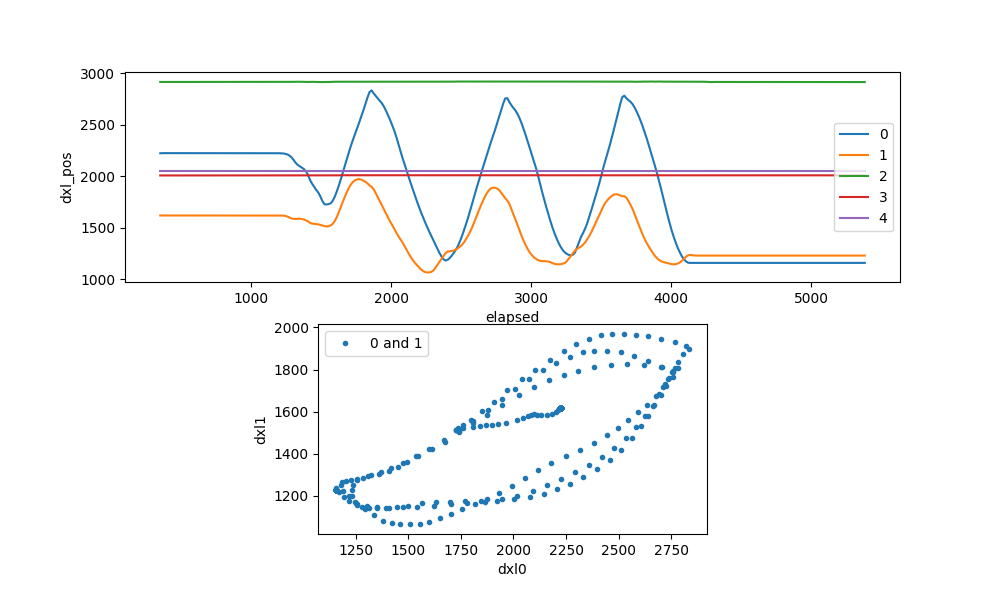

In [33]:
import pandas as pd
import numpy as np
from scipy.stats import trim_mean
import glob
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
%matplotlib widget

list_of_files = [f for f in glob.glob('./traj/*') if not os.path.isdir(f)] #take all files but not folders
latest_file = max(list_of_files, key=os.path.getctime)

file_path = latest_file
# file_path = "./data/0500um_110mm_c1_2023-12-15_20-56-08.txt"

# Read the text file into a list of lines
with open(file_path, 'r') as file:
    lines = file.readlines()

labels = ['elapsed', 'dxl_pos[0]', 'dxl_pos[1]', 'dxl_pos[2]', 'dxl_pos[3]', 'dxl_pos[4]',]
data_dict = {}
for label in labels:
    data_dict[label] = []

for line in lines:
    for label in labels:
        if(line.startswith(label)):
            data_dict[label].append(float(line.split(': ')[1]))
    if line.startswith('end'): 
        break

# Create a dataframe from the extracted values
df_raw = pd.DataFrame(data_dict)
df = None #cropped version

plt.close('all')
fig, axs = plt.subplots(2, 1, figsize=(10,6))
@interact(start_index=IntSlider(min=0, max=len(df_raw)-1, step=1, value=0),
          end_index=IntSlider(min=0, max=len(df_raw)-1, step=1, value=len(df_raw)-1))
def display_image(start_index, end_index):
    if(start_index >= end_index):
        return

    global df
    df = df_raw[start_index:end_index]
    
    axs[0].clear()
    axs[0].set_xlabel('elapsed')
    axs[0].set_ylabel('dxl_pos')
    for i in range(5):
        axs[0].plot(df['elapsed'], df[f'dxl_pos[{i}]'], label=f'{i}')
    axs[0].legend()

    axs[1].clear()
    axs[1].set_xlabel('dxl0')
    axs[1].set_ylabel('dxl1')
    axs[1].plot(df['dxl_pos[0]'], df['dxl_pos[1]'], '.', label=f'0 and 1')
    axs[1].legend()
    axs[1].set_aspect('equal', adjustable='box')
plt.show()

In [50]:
traj_df = df.copy().reset_index()
traj_df['elapsed'] = traj_df['elapsed']-traj_df['elapsed'][0]

print(len(traj_df))
traj_df

62


,index,elapsed,dxl_pos[0],dxl_pos[1],dxl_pos[2],dxl_pos[3],dxl_pos[4]
0,138,0.0,1192.0,1224.0,2919.0,2009.0,2049.0
1,139,15.0,1180.0,1252.0,2919.0,2009.0,2049.0
2,140,30.0,1187.0,1268.0,2919.0,2009.0,2049.0
3,141,44.0,1204.0,1269.0,2919.0,2010.0,2049.0
4,142,59.0,1228.0,1273.0,2919.0,2010.0,2049.0
...,...,...,...,...,...,...,...
57,195,836.0,1313.0,1144.0,2919.0,2009.0,2049.0
58,196,851.0,1282.0,1149.0,2919.0,2009.0,2049.0
59,197,866.0,1259.0,1157.0,2919.0,2009.0,2049.0
60,198,880.0,1245.0,1173.0,2919.0,2009.0,2049.0


596.6666666666666


,elapsed,dxl_pos[0],dxl_pos[1],phase
0,0.0,1192.000000,1224.000000,0.000000
1,10.0,1180.273743,1252.625698,0.016760
2,20.0,1188.329609,1268.078212,0.033520
3,30.0,1206.815642,1269.469274,0.050279
4,40.0,1232.379888,1273.782123,0.067039
...,...,...,...,...
95,950.0,2575.251397,1489.240223,1.592179
96,960.0,2524.536313,1430.765363,1.608939
97,970.0,2469.162011,1380.508380,1.625698
98,980.0,2407.223464,1334.374302,1.642458


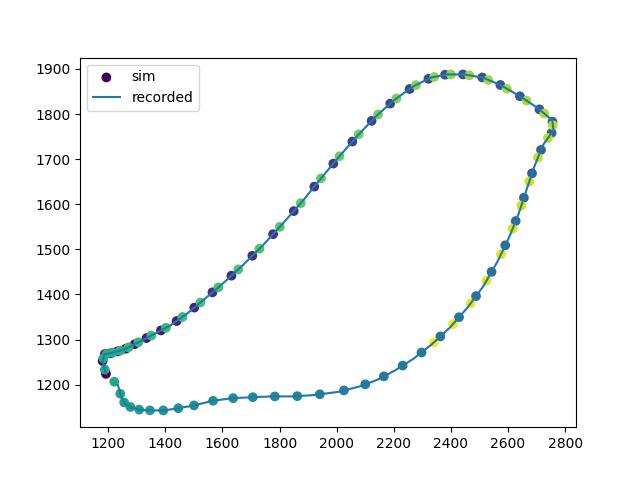

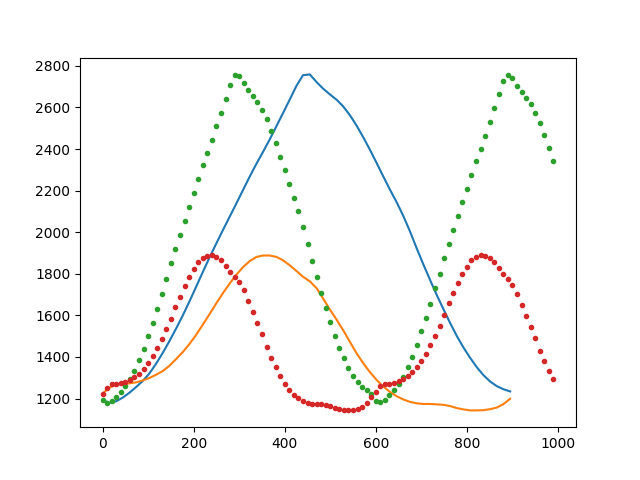

In [146]:
#simulate traj follow
elapseds = np.arange(0, 1000, 10)
speed = 1.5
period = traj_df['elapsed'][len(traj_df)-1]/speed
# period = 150

print(period)
follow_df = pd.DataFrame({'elapsed': [], 'dxl_pos[0]': [], 'dxl_pos[1]': [], 'phase': []})
for elapsed in elapseds:
    phase = elapsed/period
    progress = (phase - int(phase)) * len(traj_df) #goes from 0 to length of traj
    index = int(progress)
    index_frac = progress - index

    if(index + 1 < len(traj_df)):
        index_next = index + 1
    else:
        index_next = 0
    
    follow_df.loc[len(follow_df)] = [
        elapsed, 
        (1-index_frac)*traj_df['dxl_pos[0]'][index] + (index_frac)*traj_df['dxl_pos[0]'][index_next], 
        (1-index_frac)*traj_df['dxl_pos[1]'][index] + (index_frac)*traj_df['dxl_pos[1]'][index_next], 
        phase
    ]

plt.figure()
plt.scatter(follow_df['dxl_pos[0]'], follow_df['dxl_pos[1]'], c=follow_df['elapsed'],  label=f'sim')
plt.plot(traj_df['dxl_pos[0]'], traj_df['dxl_pos[1]'], '-', label=f'recorded')
plt.legend()

plt.figure()
plt.plot(traj_df['elapsed'], traj_df['dxl_pos[0]'], '-')
plt.plot(traj_df['elapsed'], traj_df['dxl_pos[1]'], '-')
plt.plot(follow_df['elapsed'], follow_df['dxl_pos[0]'], '.')
plt.plot(follow_df['elapsed'], follow_df['dxl_pos[1]'], '.')

follow_df

In [145]:
plt.close('all')